<a href="https://colab.research.google.com/github/gidee725/IMAGE-CLASSIFICATION_CNN/blob/main/stock_predictions_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [30]:

# Define the stock symbol and the period
stock_symbol = 'INTC'  # Intel Corporation.
start_date = '2010-01-01'
end_date = '2024-05-01'

# Download stock data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the first few rows
stock_data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,20.790001,21.030001,20.73,20.879999,13.660447,47800900
2010-01-05,20.940001,20.990000,20.60,20.870001,13.653904,52357700
2010-01-06,20.809999,20.930000,20.67,20.799999,13.608105,40037400
2010-01-07,20.730000,20.760000,20.34,20.600000,13.477261,54041500
2010-01-08,20.540001,20.889999,20.40,20.830000,13.627735,48234700


In [31]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3605 entries, 2010-01-04 to 2024-04-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3605 non-null   float64
 1   High       3605 non-null   float64
 2   Low        3605 non-null   float64
 3   Close      3605 non-null   float64
 4   Adj Close  3605 non-null   float64
 5   Volume     3605 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 197.1 KB


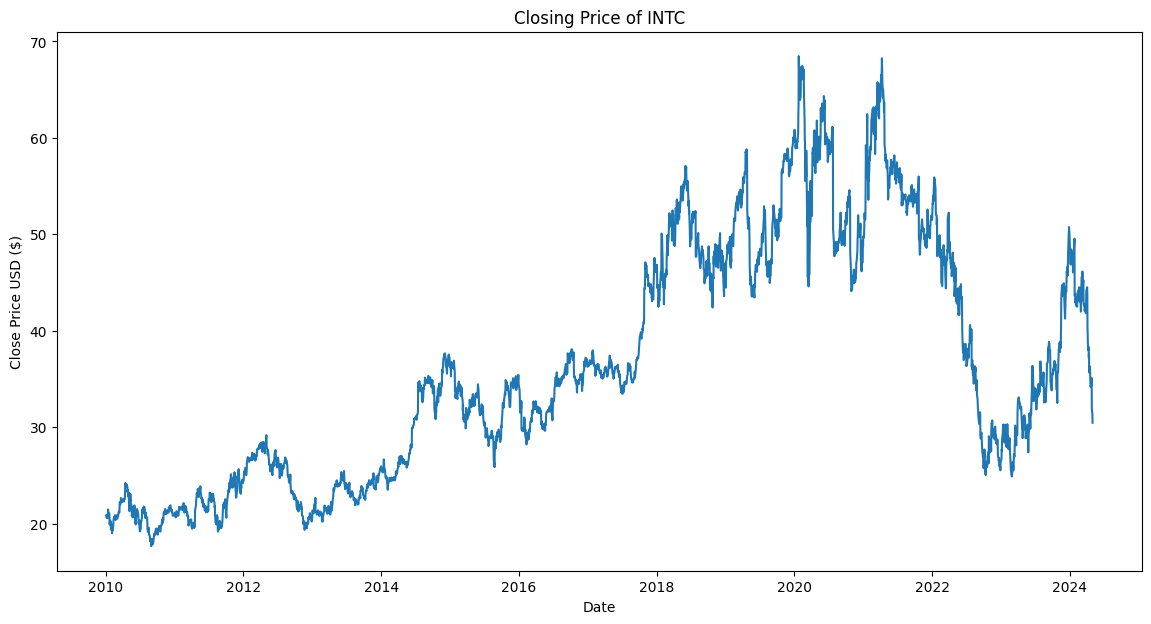

In [32]:
# Plot the closing prices
plt.figure(figsize=(14,7))
plt.title(f'Closing Price of {stock_symbol}')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()


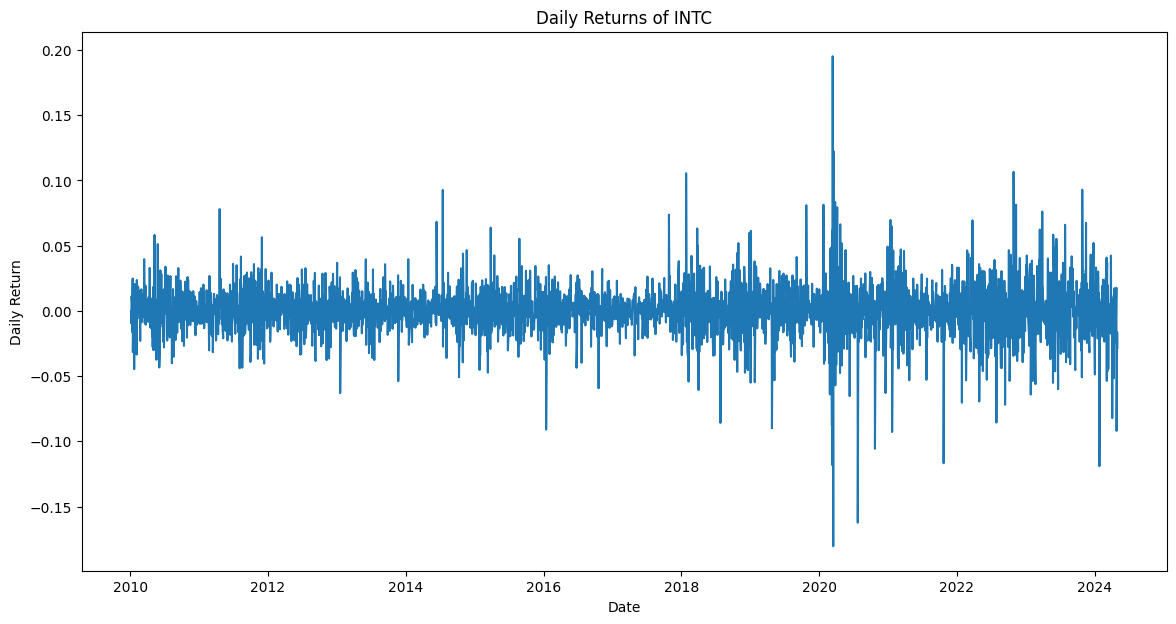

In [33]:
# Calculate daily returns
stock_data['Daily Return'] = stock_data['Close'].pct_change()

# Plot daily returns
plt.figure(figsize=(14,7))
plt.title(f'Daily Returns of {stock_symbol}')
plt.plot(stock_data['Daily Return'])
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()


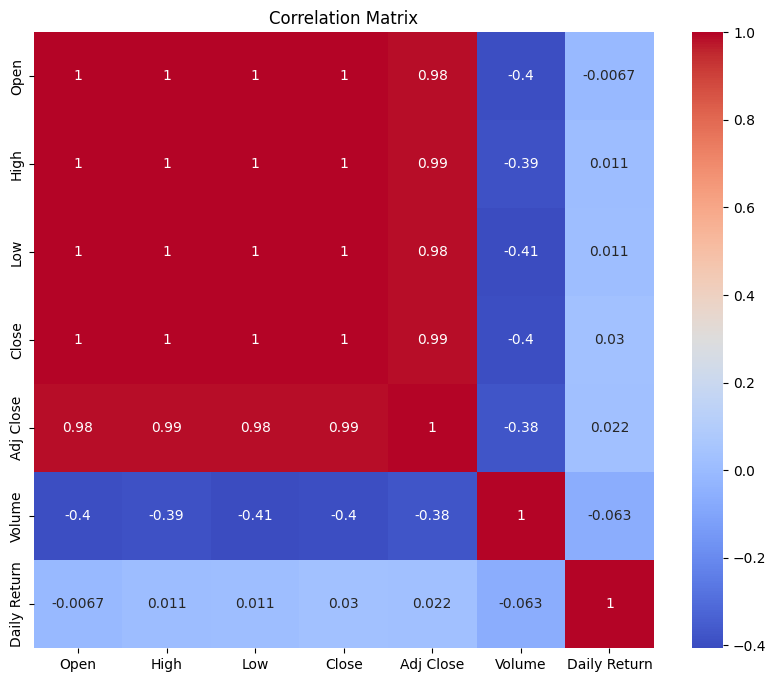

In [34]:
# Plot correlation matrix
plt.figure(figsize=(10,8))
corr_matrix = stock_data.corr()
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [35]:
# Select the 'Close' price column
data = stock_data['Close'].values
data = data.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [36]:
# Create sequences for training
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 60  # 60 days sequence
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=3)


Epoch 1/3
2824/2824 [==============================] - 100s 34ms/step - loss: 0.0034
Epoch 2/3
2824/2824 [==============================] - 100s 35ms/step - loss: 0.0019
Epoch 3/3
2824/2824 [==============================] - 96s 34ms/step - loss: 0.0017


In [38]:
# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(f'Root Mean Squared Error: {rmse}')


21/21 [==============================] - 1s 17ms/step
Root Mean Squared Error: 37.6370371786628


<ipython-input-39-cfc0430e764e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


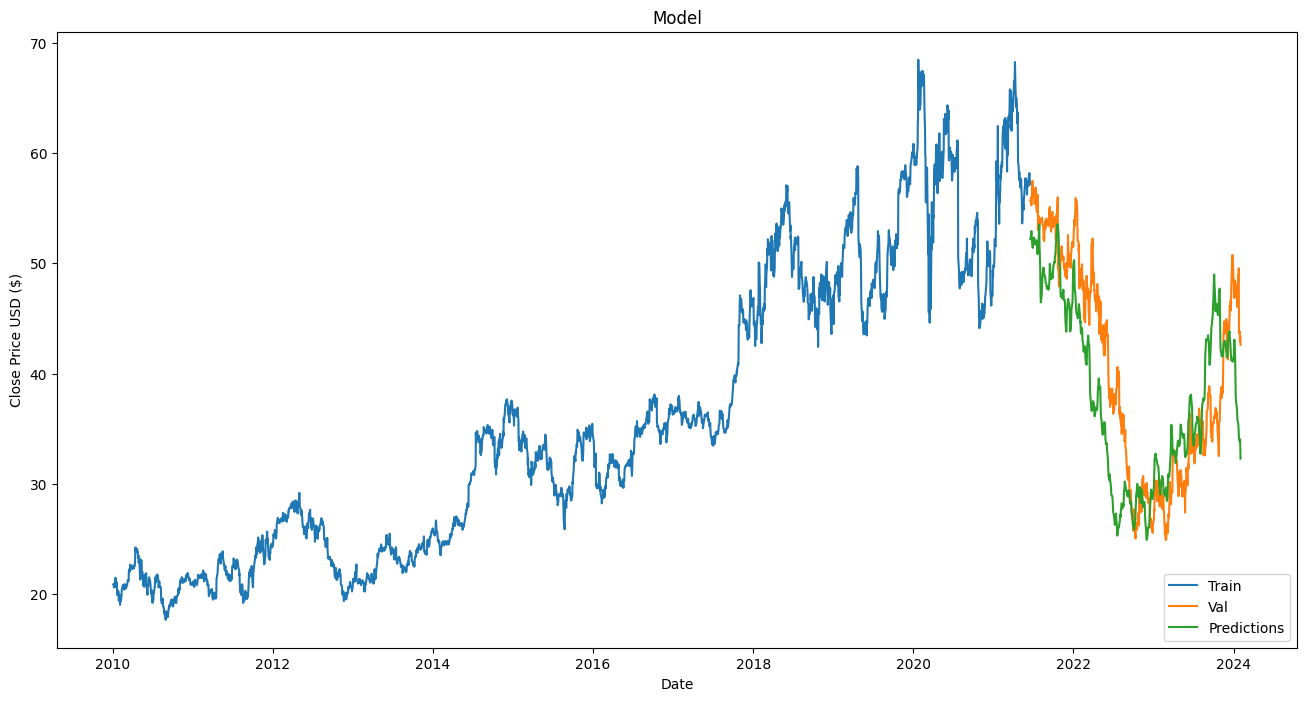

In [39]:
# Plot the results
train = stock_data[:train_size]
valid = stock_data[train_size:train_size + len(y_test)]

valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [41]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Reshape
from tensorflow.keras.models import Sequential

In [42]:
# Define the model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(2))
model.add(Flatten())  # Flatten the output of the convolutional layer
model.add(Dense(10, activation='relu'))
model.add(Reshape((5, 2)))  # Reshape to (timesteps, features) for LSTM
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [43]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/10
89/89 [==============================] - 3s 7ms/step - loss: 0.0661
Epoch 2/10
89/89 [==============================] - 1s 7ms/step - loss: 0.0028
Epoch 3/10
89/89 [==============================] - 1s 7ms/step - loss: 0.0016
Epoch 4/10
89/89 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 5/10
89/89 [==============================] - 1s 9ms/step - loss: 0.0011
Epoch 6/10
89/89 [==============================] - 1s 9ms/step - loss: 0.0011
Epoch 7/10
89/89 [==============================] - 1s 10ms/step - loss: 0.0011
Epoch 8/10
89/89 [==============================] - 1s 10ms/step - loss: 0.0010
Epoch 9/10
89/89 [==============================] - 1s 7ms/step - loss: 0.0010
Epoch 10/10
21/21 [==============================] - 1s 3ms/step


In [44]:
# Inverse transform y_test for RMSE calculation
y_test = scaler.inverse_transform(y_test)
# Calculate RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 0.9307540137540563


<ipython-input-45-cfc0430e764e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


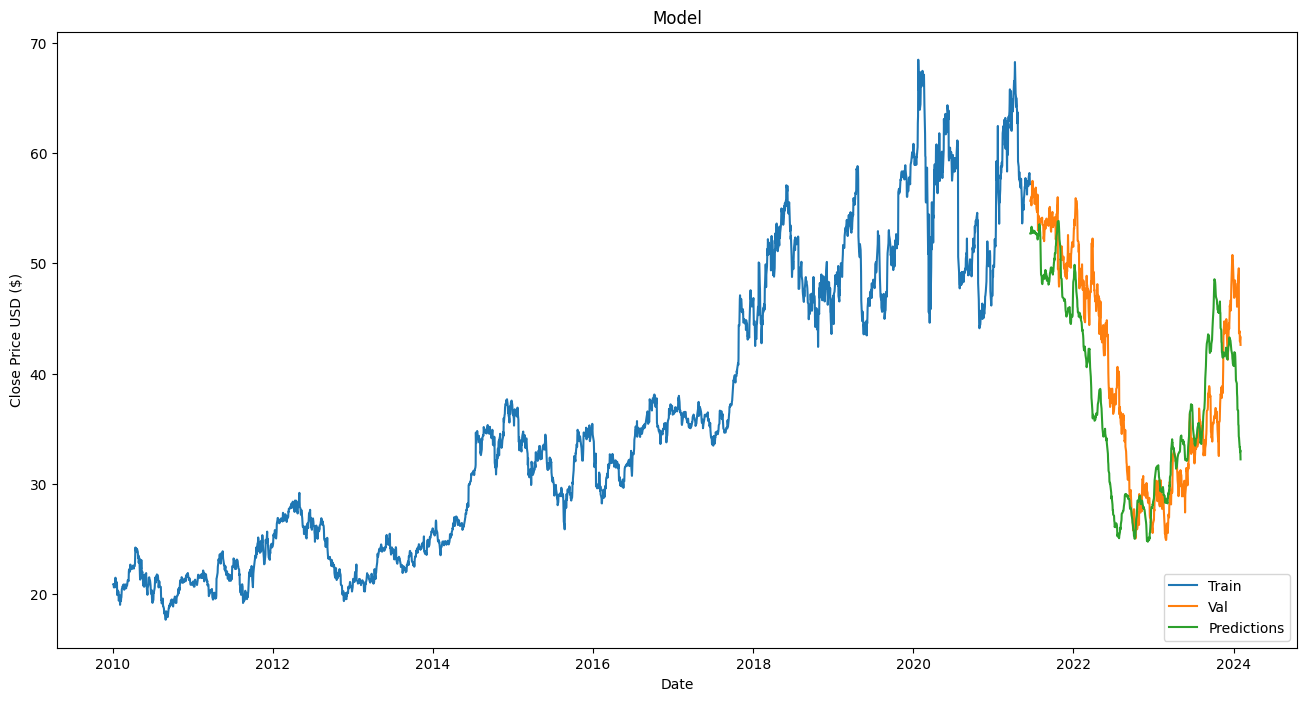

In [45]:
# Plot the results
train = stock_data[:train_size]
valid = stock_data[train_size:train_size + len(y_test)]

valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [46]:
# Calculate technical indicators
stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['EMA_10'] = stock_data['Close'].ewm(span=10, adjust=False).mean()
stock_data['EMA_5'] = stock_data['Close'].ewm(span=5, adjust=False).mean()

In [47]:
# Drop rows with NaN values created by rolling/ewm calculations
stock_data.dropna(inplace=True)
# Select the features (Close price and technical indicators)
features = stock_data[['Close', 'SMA_200', 'SMA_50', 'EMA_10', 'EMA_5']].values
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Separate scaler for the 'Close' price
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_close.fit_transform(features[:, 0].reshape(-1, 1))

In [48]:
# Prepare the training and testing datasets
train_size = int(len(scaled_features) * 0.8)
train_data = scaled_features[:train_size]
test_data = scaled_features[train_size:]

# Function to create sequences for training/testing
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Assuming we want to predict the 'Close' price
    return np.array(X), np.array(y)

seq_length = 60  # 60 days sequence

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [49]:
# Define the model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(seq_length, 5)))  # 5 features
model.add(MaxPooling1D(2))
model.add(Flatten())  # Flatten the output of the convolutional layer
model.add(Dense(10, activation='relu'))
model.add(Reshape((5, 2)))  # Reshape to (timesteps, features) for LSTM
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
84/84 [==============================] - 4s 7ms/step - loss: 0.0874
Epoch 2/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0088
Epoch 3/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 4/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0019
Epoch 5/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0015
Epoch 6/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0014
Epoch 7/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0012
Epoch 8/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 9/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0010
Epoch 10/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0012


In [50]:
# Predict on test data
predictions = model.predict(X_test)

# Inverse transform the predictions using the separate 'Close' scaler
predictions = scaler_close.inverse_transform(predictions)

# Inverse transform y_test for RMSE calculation
y_test = scaler_close.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f'Root Mean Squared Error: {rmse}')


20/20 [==============================] - 1s 5ms/step
Root Mean Squared Error: 2.1895319439418897


<ipython-input-52-efac76a9a591>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


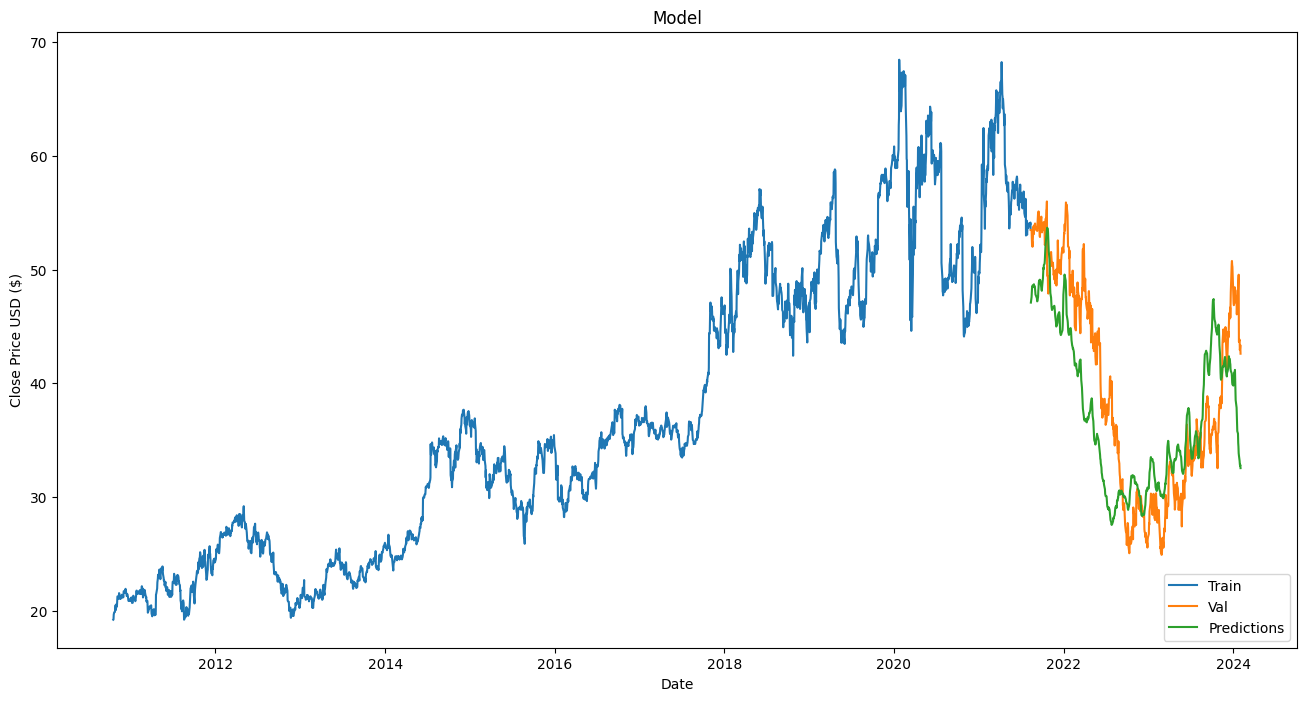

In [52]:
# Plot the results
train = stock_data[:train_size]
valid = stock_data[train_size:train_size + len(predictions)]

valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
tra